# Word2vec implementation in Keras

In [2]:
# Imports
import requests
import collections
import os
import re
import zipfile
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from tqdm.notebook import tqdm
from typing import Callable, Union

import tensorflow as tf
tf.random.set_seed(rng_seed)
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Reshape, dot, Embedding, Dot
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import plot_model, to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from bs4 import BeautifulSoup
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
eng_stopwords = nltk_stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from matplotlib import pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Silence NumbaPerformanceWarning (for UMAP)
from numba.errors import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Clustering
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import hdbscan

[nltk_data] Downloading package wordnet to /Users/triki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/triki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Utility functions

In [2]:
def load_text_data_from_url(url: str, data_dir: str = 'data') -> str:
    '''Loads data from url. Data will be downloaded to disk if non-existent.
    
    Args:
        url : str
            Url to fetch data from.
        data_dir : str
            Data directory to download the data to.
        
    Returns:
        content : str
            Text content of the data
    '''
    filename = f'{data_dir}{os.path.sep}{os.path.basename(url)}'
    
    # Download file if not present
    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(r.content)
        return r.text
    else:
        with open(filename, 'r', encoding='utf-8-sig') as f:
            content = f.read()
    
    return content

In [3]:
# Build dataset
# TODO: Build separate datasets for train, val and test.
# Otherwhise the datasets will become too corrolated, due to the fact that
# we create skipgrams which might overlap a lot.
# TODO: Look into COVID-19 dataset from kaggle:
# https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge
book_url = 'http://www.gutenberg.org/cache/epub/345/pg345.txt'
book_content = load_text_data_from_url(book_url)
#book_data, (book_data_pairs, book_data_labels), book_dictionary, rev_book_dictionary, real_vocab_size = build_dataset(book_content, max_vocab_size, context_window_size)
#book_data_pairs_hot = to_categorical(book_data_pairs, real_vocab_size + 1)
#del book_content # Save memory

In [4]:
def remove_urls(text: str) -> str:
    url_re = r'(?i)(?:(?:(https?|ftp|file):\/\/|www\.|ftp\.)|([\w\-_]+(?:\.|\s*\[dot\]\s*[A-Z\-_]+)+))([A-Z\-\.,@?^=%&amp;:\/~\+#]*[A-Z\-\@?^=%&amp;\/~\+#]){2,6}?'
    return re.sub(url_re, '', text)

In [5]:
def process_text(text: str) -> str:
    
    # Remove potential HTML entries
    text = BeautifulSoup(text, 'lxml').get_text()
    
    # Remove URLs
    text = remove_urls(text)
    
    # Lower case and remove punctuation
    text = ' '.join(text_to_word_sequence(text))
    
    # Filter function, remove stopwords, numbers
    # and strings that have length 1 or less
    f = lambda t: (t not in eng_stopwords) and \
                  (not t.isnumeric()) and \
                  (len(t) > 1)
    
    text = ' '.join([t for t in text.split() if f(t)])
    
        # Apply lemmatization
    text = ' '.join([wnl.lemmatize(t) for t in text.split()])
    
    return text

In [6]:
class SkipgramDataGenerator(Sequence):
    '''
    Data generator for genering skipgram word pairs ((target, context) -> positive (1) or negative (0)).
    Inherits tensorflow.keras.utils.Sequence
    '''
    def __init__(self,
                 skipgram_pairs: list,
                 categorical_pairs: bool,
                 skipgram_labels: list,
                 batch_size: int,
                 indices: np.ndarray = None,
                 shuffle: bool = True):
        '''Initialization of the tokenized skipgram data generator
        
        Args:
            skipgram_pairs : list
                TODO
            skipgram_labels : list
                TODO
            batch_size : int
                Number of skipgram word pairs to process at once per batch
            categorical_pairs : bool = False
                Whether to use categorical (one-hot encoded) target/context pairs
            indices : np.ndarray
                TODO
            shuffle : bool = True
                Whether to shuffle the data at generation
        '''
        self.skipgram_pairs = skipgram_pairs
        self.categorical_pairs = categorical_pairs
        self.skipgram_labels = skipgram_labels
        if indices is None:
            if categorical_pairs:
                self.indices = np.arange(self.skipgram_pairs.shape[1])
            else:
                self.indices = np.arange(self.skipgram_pairs.shape[0])
        else:
            self.indices = indices
        self.num_skipgram_pairs = len(self.indices)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def on_epoch_end(self):
        '''
        Shuffles indices after each epoch
        '''
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return self.num_skipgram_pairs // self.batch_size
    
    def __getitem__(self, batch_nr: int):
        '''Generate one batch (pairs, labels) of data
        
        Args:
            batch_nr : int
                Batch number
        
        Returns:
            (pairs, labels) : tuple
                Batch of skipgram word pairs and labels
        '''
        return self.get_batch(batch_nr)

    def _get_batch_indices(self, batch_nr: int):
        '''Gets indices for a given batch number
        
        Args:
            batch_nr : int
                Batch number
            
        Returns:
            indices : np.ndarray
                Indices of the current batch
        '''
        return self.indices[batch_nr * self.batch_size:(batch_nr + 1) * self.batch_size]
    
    def get_batch(self, batch_nr: int):
        '''Gets a batch of data (pairs, labels) containing batch_size samples 
        
        Args:
            batch_nr : int
                Batch number
        
        Returns:
            (pairs, labels) : tuple
                Batch of skipgram word pairs and labels
        '''
        # Generate indices of the batch
        batch_indices = self._get_batch_indices(batch_nr)
        
        # Get batch
        if self.categorical_pairs:
            X_batch = self.skipgram_pairs[:, batch_indices]
        else:
            X_batch = self.skipgram_pairs[batch_indices].T
        y_batch = self.skipgram_labels[batch_indices]
        
        # [None] value fixes the following error (assuming tf version < 2.2):
        # https://stackoverflow.com/questions/59317919/warningtensorflowsample-weight-modes-were-coerced-from-to
        return list(X_batch), y_batch, [None]

In [7]:
def create_texts_gen(texts):
    '''
    Yields processed texts
    '''
    for text in texts:
        yield process_text(text)

def create_skipgram_pairs(texts: list, max_vocab_size: int, sampling_window_size: int,
                          num_negative_samples: int, categorical_pairs: bool = False):
    '''
    Creates skipgram word pairs
    '''
    print('Building vocabulary...')
    tokenizer = Tokenizer(max_vocab_size)
    tokenizer.fit_on_texts(create_texts_gen(texts))
    word_to_idx = tokenizer.word_index
    idx_to_word = tokenizer.index_word
    vocab_size = len(word_to_idx)
    print('Done!')
    
    print('Creating skipgram word pairs...')
    skipgram_pairs, skipgram_labels = [], []
    for text in create_texts_gen(texts):

        # Tokenize text before creating skipgrams
        tokenized_text = tokenizer.texts_to_sequences([text])[0]

        corpus_pairs, corpus_labels = skipgrams(
            tokenized_text,
            vocab_size,
            sampling_table=make_sampling_table(vocab_size + 1),
            window_size=sampling_window_size,
            negative_samples=num_negative_samples
        )
        

        skipgram_pairs += corpus_pairs
        skipgram_labels += corpus_labels

    # Convert to numpy
    skipgram_pairs = np.array(skipgram_pairs)
    skipgram_labels = np.array(skipgram_labels)

    # One-hot encode pairs if needed
    if categorical_pairs:
        skipgram_pairs = to_categorical(skipgram_pairs.T, vocab_size + 1)

    print('Done!')
    
    return skipgram_pairs, skipgram_labels, word_to_idx, idx_to_word, vocab_size

In [8]:
# Constants
max_vocab_size = 10000
sampling_window_size = 5
vector_dim = 300
num_epochs = 20
batch_size = 128
num_negative_samples = 10

In [24]:
texts = [book_content]
data_pairs, data_labels, word_to_idx, idx_to_word, data_vocab_size = create_skipgram_pairs(
    texts,
    max_vocab_size,
    sampling_window_size,
    num_negative_samples,
    categorical_pairs=False
)

Building vocabulary...
Done!
Creating skipgram word pairs...
Done!


In [25]:
data_pairs.shape, data_labels.shape

((1710049, 2), (1710049,))

In [10]:
data_pairs.shape

(2, 1742257, 8704)

In [11]:
train_indices, val_indices = train_test_split(np.arange(data_pairs.shape[1]), test_size=0.02)
val_indices, test_indices = train_test_split(val_indices, test_size=0.5)
#train_pairs, train_labels = data_pairs[train_indices], data_labels[train_indices]
#val_pairs, val_labels = data_pairs[val_indices], data_labels[val_indices]
#test_pairs, test_labels = data_pairs[test_indices], data_labels[test_indices]
#train_pairs, val_pairs, train_labels, val_labels = train_test_split(data_pairs, data_labels, test_size=0.02)
#val_pairs, test_pairs, val_labels, test_labels = train_test_split(val_pairs, val_labels, test_size=0.5)

In [12]:
# Prepare data generators
train_gen = SkipgramDataGenerator(data_pairs, True, data_labels, batch_size, indices=train_indices)
val_gen = SkipgramDataGenerator(data_pairs, True, data_labels, batch_size, indices=val_indices)
test_gen = SkipgramDataGenerator(data_pairs, True, data_labels, batch_size, indices=test_indices)

In [13]:
# TODO: Add regularization to layers (??)

# Create the model
def build_model_embedding(vocab_size: int, vector_dim: int):
    '''
    TODO: Docs
    '''
    # Input to network
    input_target = Input((1,), name='input_target')
    input_context = Input((1,), name='input_context')

    # Embedding layer
    embedding = Embedding(vocab_size + 1, vector_dim, input_length=1, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute (unnormalized) cosine similarity
    dot_product = Dot(axes=1, name='dot_product')([target, context])
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Create (slower) model using Dense instead of Embedding layer
def build_model_dense(vocab_size: int, vector_dim: int):
    '''
    TODO: Docs
    '''
    # Input to network
    input_shape = (vocab_size + 1,)
    input_target = Input(input_shape, name='input_target')
    input_context = Input(input_shape, name='input_context')

    # Embedding layer using Dense layers
    embedding = Dense(vector_dim, input_shape=input_shape, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute (unnormalized) cosine similarity
    dot_product = Dot(axes=1, name='dot_product')([target, context])
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
w2v_model = build_model_dense(data_vocab_size, vector_dim)
w2v_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_target (InputLayer)       [(None, 8704)]       0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      [(None, 8704)]       0                                            
__________________________________________________________________________________________________
embedding (Dense)               (None, 300)          2611500     input_target[0][0]               
                                                                 input_context[0][0]              
__________________________________________________________________________________________________
target_word_vector (Reshape)    (None, 300, 1)       0           embedding[0][0]              

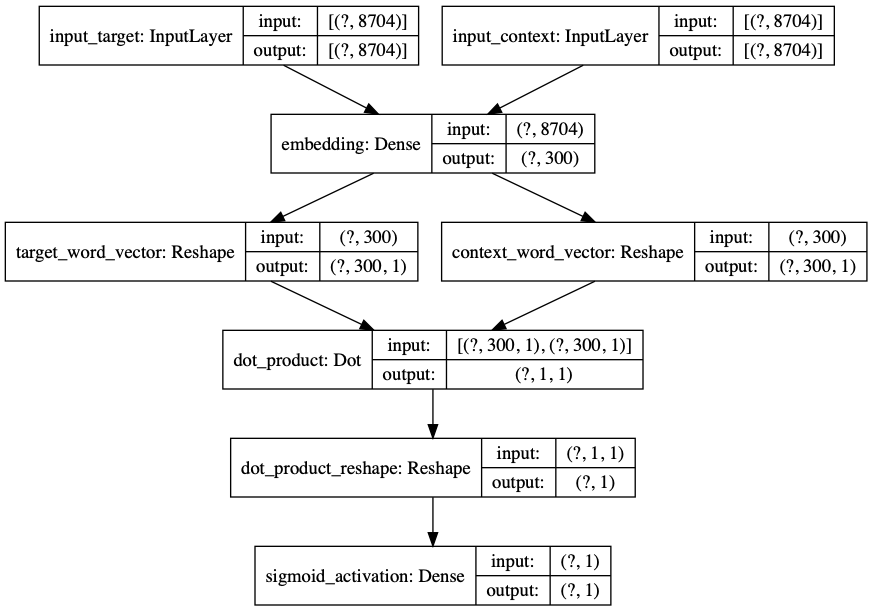

In [15]:
# Visualize model using PyDot and GraphViz
plot_model(w2v_model, show_shapes=True, to_file='word2vec_model.png')

In [16]:
# Load model from file
#w2v_model = load_model('word2vec_model.h5')

In [17]:
class IntermediateUMAPReductionCallback(Callback):
    '''
    TODO: Docs
    '''
    
    def __init__(self, plot_embedding: bool = True, data: list = None, rev_data_dictionary: dict = None):
        '''
        TODO: Docs
        '''
        self.plot_embedding = plot_embedding
        self.data = data
        self.rev_data_dictionary = rev_data_dictionary
        self.embeddings = []
    
    def get_embedding(self, epoch: int):
        '''
        TODO: Docs
        '''
        assert epoch < len(self.embeddings), f'Invalid epoch number: {epoch}'
        return self.embeddings[epoch]
    
    def __plot_embedding__(self, epoch: int, num_words: int = 100):
        '''
        TODO: Docs
        '''
        assert self.data != None, 'Data is required for plotting'
        assert self.rev_data_dictionary != None, 'Reversed data dictionary is required for plotting'
        embedding = self.get_embedding(epoch)
        
        # Plot embedded vectors in 2D
        plt.figure(figsize=(5, 5))
        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.25)

        # Annotate
        for word_i in self.data[:num_words]:
            word = self.rev_data_dictionary[word_i]
            word_vec = embedding[word_i]
            plt.annotate(word, (word_vec[0], word_vec[1]))
        plt.show()
    
    def on_epoch_end(self, epoch, logs={}):
        '''
        TODO: Docs
        '''
        print(f'Creating word embeddings...')
        
        # Create intermediate UMAP word embeddings
        word_embeddings = self.model.layers[2].get_weights()[0]
        word_embeddings_2d = umap.UMAP().fit_transform(word_embeddings)
        self.embeddings.append(word_embeddings_2d)
        
        if self.plot_embedding:
            self.__plot_embedding__(epoch)

In [18]:
# Define callbacks
#checkpoint = ModelCheckpoint('checkpoints/model-best-{epoch:02d}.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')  
#umap_reduc = IntermediateUMAPReductionCallback(data=book_data, rev_data_dictionary=rev_book_dictionary)
#cb = [checkpoint, umap_reduc]

In [19]:
# Train model
model_hist = w2v_model.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen
)

Train for 13339 steps, validate for 136 steps
Epoch 1/20
13339/13339 [==============================] - 414s 31ms/step - loss: 0.2734 - accuracy: 0.9174 - val_loss: 0.1963 - val_accuracy: 0.9295
Epoch 2/20
13339/13339 [==============================] - 422s 32ms/step - loss: 0.1147 - accuracy: 0.9594 - val_loss: 0.1967 - val_accuracy: 0.9334
Epoch 3/20
13339/13339 [==============================] - 433s 32ms/step - loss: 0.0669 - accuracy: 0.9805 - val_loss: 0.2166 - val_accuracy: 0.9336
Epoch 4/20
13339/13339 [==============================] - 435s 33ms/step - loss: 0.0536 - accuracy: 0.9858 - val_loss: 0.2172 - val_accuracy: 0.9343
Epoch 5/20
 3332/13339 [======>.......................] - ETA: 5:27 - loss: 0.0339 - accuracy: 0.9903

KeyboardInterrupt: 

In [ ]:


# Reshape X to fit Dense model
X_train_hot_resh = X_train_hot.reshape(2, X_train_hot.shape[0], real_vocab_size + 1)
X_val_hot_resh = X_val_hot.reshape(2, X_val_hot.shape[0], real_vocab_size + 1)
X_test_hot_resh = X_test_hot.reshape(2, X_test_hot.shape[0], real_vocab_size + 1)

# Uncomment to fit model
model_hist = w2v_model.fit(
    list(X_train_hot_resh),
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=cb,
    validation_data=(list(X_val_hot_resh), y_val)
)

In [ ]:
# TODO: Run a UMAP on all embeddings at once ((m x n) x 300 matrix)
# to get a less biased result. The plots above from training might be too correlated.

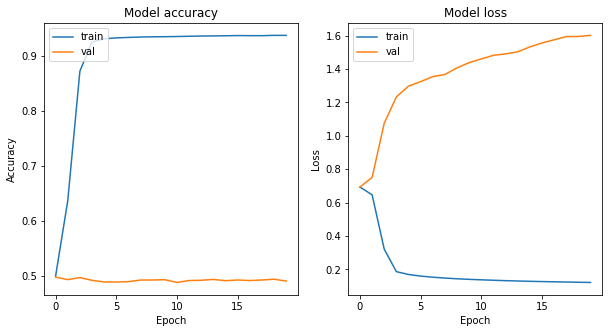

In [44]:
# Summarize history for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
# Evaluate train accuracy
y_train_pred = w2v_model.predict(list(X_train_hot_resh))
y_train_auc = roc_auc_score(y_train, y_train_pred)
print(f'Train AUC: {y_train_auc}')

Train accuracy: 0.994179299316593


In [50]:
# Evaluate test accuracy
y_test_pred = w2v_model.predict(list(X_test_hot_resh))
y_test_auc = roc_auc_score(y_test, y_test_pred)
print(f'Test AUC: {y_test_auc}')

Test accuracy: 0.4918765321544173


In [18]:
# Save last model to file
w2v_model.save('checkpoints/last_model.h5')

## Analyze word embeddings

In [19]:
# Load best model from file
#best_model_path = 'checkpoints/last_model.h5'
best_model_path = 'checkpoints/model-best-02.h5'
w2v_model = load_model(best_model_path)

In [17]:
# Extract the learned embeddings from the NN
word_embeddings = w2v_model.layers[2].get_weights()[0]
word_embeddings_lst = list(word_embeddings)

In [29]:
word_embeddings.shape

(8704, 300)

In [28]:
word_to_vec = {word: word_embeddings[idx] for word, idx in train_gen.tokenizer.word_index.items()}

In [100]:
def most_similar_vec(word_vec: np.ndarray, idx_to_word: dict, word_embeddings: np.ndarray, n: int = 10, skip_first: int = 0) -> list:
    
    # Compute cosine similarities
    cos_sims = word_vec @ word_embeddings.T / (np.linalg.norm(word_vec) * np.linalg.norm(word_embeddings, axis=1))
    cos_sims = np.clip(cos_sims, 0, 1) 
    sorted_indices = np.argsort(cos_sims)[::-1]
    sorted_cos_sims = cos_sims[sorted_indices][skip_first:n + skip_first]
    sorted_words = [idx_to_word[idx] for idx in sorted_indices[skip_first:n + skip_first]]
    
    # Create word similarity pairs
    pairs = list(zip(sorted_words, sorted_cos_sims))
    
    return pairs

def most_similar_word(word: str, word_to_vec: dict, idx_to_word: dict, word_embeddings: np.ndarray, n: int = 10) -> list:
    return most_similar_vec(word_to_vec[word], idx_to_word, word_embeddings, n, skip_first=1)

In [117]:
most_similar_word('crown', word_to_vec, train_gen.idx_to_word, word_embeddings)

[("deputy's", 0.444165),
 ('spelling', 0.438531),
 ('laugh', 0.37906456),
 ('pack', 0.37563163),
 ('king', 0.36181182),
 ('arrived', 0.35903168),
 ('misled', 0.3446326),
 ('farmhouse', 0.340779),
 ('peculiarity', 0.32309657),
 ('phonetic', 0.31885847)]

In [102]:
most_similar_vec(word_to_vec['king'] - word_to_vec['man'] + word_to_vec['woman'], train_gen.idx_to_word, word_embeddings)

[('king', 0.7379039),
 ('woman', 0.5101631),
 ('headline', 0.36196136),
 ('eversfield', 0.32880777),
 ('society', 0.30612418),
 ('redeemed', 0.30017808),
 ('dance', 0.2992828),
 ('kensington', 0.2978997),
 ('trailing', 0.28727844),
 ("dudding's", 0.28389567)]

In [18]:
word_embeddings_2d = PCA(n_components=2).fit_transform(word_embeddings)

NameError: name 'book_data' is not defined

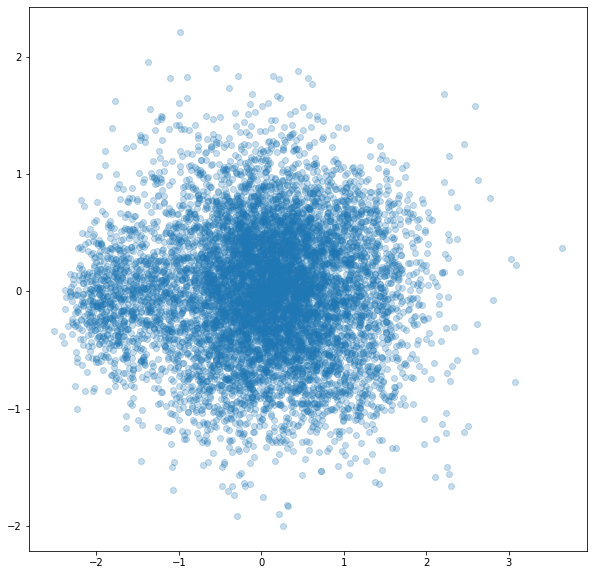

In [19]:
# Plot embedded vectors in 2D
plt.figure(figsize=(10, 10))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.25)

# Annotate
for word_i in book_data[:100]:
    word = rev_book_dictionary[word_i]
    word_vec = word_embeddings_2d[word_i]
    plt.annotate(word, (word_vec[0], word_vec[1]))
plt.show()

In [54]:
# Tarzan - Man + Woman = Jane?
tarzan_vec = word_embeddings[book_dictionary['tarzan']]
man_vec = word_embeddings[book_dictionary['man']]
woman_vec = word_embeddings[book_dictionary['woman']]
jane_vec = word_embeddings[book_dictionary['jane']]
jane_vec_pred = tarzan_vec - man_vec + woman_vec

### Utility functions

In [55]:
def distance(a: np.ndarray, b: np.ndarray):
    '''
    TODO: Docs
    '''
    return np.linalg.norm(a - b)

def closest(target: np.ndarray, word_embeddings: np.ndarray, rev_book_dictionary: dict, n: int=10):
    '''
    TODO: Docs
    '''
    target_mat = np.tile(target, (word_embeddings.shape[0], 1))
    diff = word_embeddings - target_mat
    distances = np.linalg.norm(diff, axis=1)
    sorted_order = np.argsort(distances)[:n]
    closest_words = [rev_book_dictionary[idx + 1] for idx in sorted_order]
    return closest_words

In [56]:
# TODO: Find top words close to jane_vec_pred
print(closest(jane_vec_pred, word_embeddings, rev_book_dictionary))

['why', 'him', 'recollected', 'the', 'deathly', 'been', 'of', 'this', 'haven', 'twice']


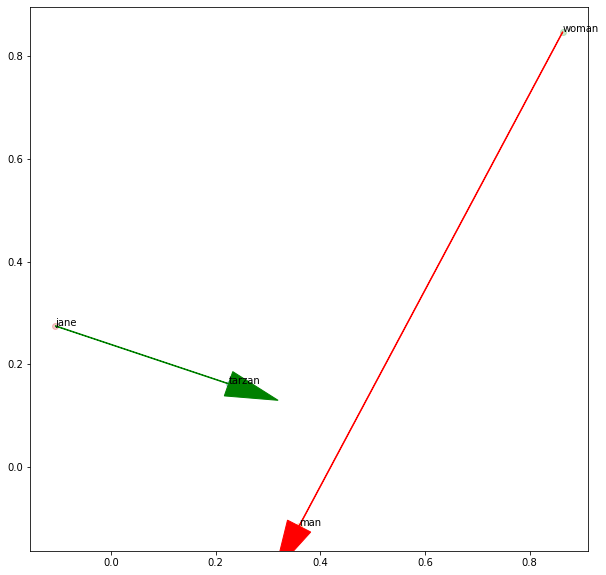

In [57]:
# TODO: Create utility function 'arrow_plot'
# Plotting tarzan, man, woman, jane
target_words = ['tarzan', 'man', 'woman', 'jane']
target_word_vecs = [word_embeddings_2d[book_dictionary[word]] for word in target_words]

# TODO: Ensure that we use a dim. reduc. method that preserves parallelism, i.e PCA
plt.figure(figsize=(10, 10))
for word, word_vec in zip(target_words, target_word_vecs):
    plt.scatter(word_vec[0], word_vec[1], alpha=0.25)
    plt.annotate(word, (word_vec[0], word_vec[1]))

man_to_woman = target_word_vecs[target_words.index('man')] - target_word_vecs[target_words.index('woman')]
tarzan_to_jane = target_word_vecs[target_words.index('tarzan')] - target_word_vecs[target_words.index('jane')]
plt.arrow(*target_word_vecs[target_words.index('woman')], *man_to_woman, head_width=0.05, head_length=0.1, color='r')
plt.arrow(*target_word_vecs[target_words.index('jane')], *tarzan_to_jane, head_width=0.05, head_length=0.1, color='g')
    
plt.show()

# Scrapyard

In [24]:
'''
def build_dataset(words: list, num_words: int = -1):
    
    # Create a dictionary for word counts
    count = [['UNK', -1]]
    if num_words == -1:
        num_words = len(words)
        
    # TODO: Fix words
    count.extend(collections.Counter(words).most_common(num_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data, count, dictionary, reversed_dictionary
'''

"\ndef build_dataset(words: list, num_words: int = -1):\n    \n    # Create a dictionary for word counts\n    count = [['UNK', -1]]\n    if num_words == -1:\n        num_words = len(words)\n        \n    # TODO: Fix words\n    count.extend(collections.Counter(words).most_common(num_words - 1))\n    dictionary = dict()\n    for word, _ in count:\n        dictionary[word] = len(dictionary)\n    \n    data = list()\n    unk_count = 0\n    for word in words:\n        if word in dictionary:\n            index = dictionary[word]\n        else:\n            index = 0  # dictionary['UNK']\n            unk_count += 1\n        data.append(index)\n    count[0][1] = unk_count\n    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))\n\n    return data, count, dictionary, reversed_dictionary\n"

In [3]:
'''
def build_dataset(text: str, max_vocab_size: int, context_window_size: int, seed: int = None):
    '''
    TODO: Docs
    '''
    # Tokenize the text
    tokenizer = Tokenizer(max_vocab_size)
    tokenizer.fit_on_texts([text])
    text_tokenized = text_to_word_sequence(text)
    
    # Extract word dictionary
    word_dict = tokenizer.word_index
    num_words = len(word_dict)
    rev_word_dict = tokenizer.index_word
    data = [word_dict[word] for word in text_tokenized]
    
    # Create data samples for valid context words and negative samples
    sampling_table = make_sampling_table(num_words + 1)
    pairs, labels = skipgrams(data, num_words, window_size=context_window_size, sampling_table=sampling_table, seed=seed)
    pairs = np.array(pairs)
    labels = np.array(labels)
    
    return data, (pairs, labels), word_dict, rev_word_dict, num_words
'''

In [59]:
#sampling_table = make_sampling_table(1000)
pairs = skipgrams(np.arange(1000), 1000)[0]
len(pairs)

15944